# Import packages

In [1]:
#!pip install pybounds

In [2]:
#!pip install braid_tools

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import pybounds
import seaborn as sns

from braid_analysis import braid_filemanager
from braid_analysis import braid_slicing
from braid_analysis import braid_analysis_plots
from braid_analysis import flymath #fly_plot_lib import flymath
from matplotlib.colors import LogNorm



C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
def unwrap_angle(z, correction_window_for_2pi=100, n_range=2, plot=False):

    smooth_zs = np.array(z[0:2])
    for i in range(2, len(z)):
        first_ix = np.max([0, i-correction_window_for_2pi])
        last_ix = i

        nbase = np.round( (smooth_zs[-1] - z[i])/(2*np.pi) )

        candidates = []
        for n in range(-1*n_range, n_range):
            candidates.append(n*2*np.pi+nbase*2*np.pi+z[i])
        error = np.abs(candidates - np.mean(smooth_zs[first_ix:last_ix])) 
        smooth_zs = np.hstack(( smooth_zs, [candidates[np.argmin(error)]] ))
    if plot:
        plt.plot(smooth_zs, '.', color='black', markersize=1)
        
    return smooth_zs

In [5]:
def compute_angular_dispersion(traj_list,start,end,plotting=False,ax=None):
    '''
    
    '''
    angdisps = np.empty((end-start,len(traj_list)))
    angdisps[:,:] = np.nan
    for i in range(len(traj_list)):
        s = min([len(traj_list[i].iloc[start:]),end-start])
        if start<len(traj_list[i]):
            starting_value = traj_list[i]['heading_unwrapped'].iloc[start]
            angdisps[:s,i] = np.abs(traj_list[i]['heading_unwrapped'].iloc[start:s+start].values-starting_value)
        else:
            angdisps[:,i] = np.nan
    
    if plotting:
        m = np.nanmean(angdisps,axis=1)
        se = np.nanstd(angdisps,axis=1)/np.sqrt(angdisps.shape[1] - np.isnan(angdisps).sum(axis=1))
        if ax is None:
            fig,ax = plt.subplots();
        ax.plot(np.arange(start,end),np.nanmean(angdisps,axis=1));
        ax.fill_between(np.arange(start,end),
                        m-se,m+se,alpha=0.5)
    
    return angdisps

In [6]:
def get_mean_over_time(traj_list,name,dur):
    '''
    Accepts list of trajectory dataframes with:
    name = column label of variable of interest, and 
    dur = desired trajectory duration in samples. 
    
    Returns the numpy array of the VOI across
    the trajectory duration and the mean over time
    ignoring NaN.
    '''
    vals = np.zeros((dur,len(traj_list)))
    vals[:,:] = np.nan
    
    count=0
    for trajec in traj_list:
        s = min([len(trajec),dur])
        vals[:s,count] = trajec[name].iloc[:s]
        count+=1
    
    return vals,np.nanmean(vals,axis=1),np.nanstd(vals,axis=1)/np.sqrt(vals.shape[1] - np.isnan(vals).sum(axis=1))

In [7]:
def create_unwrapped_heading_column(traj_list,headingname):
    '''
    Accepts list of trajectory dataframes with:
    headingname = column label of heading variable.
    
    Creates a new column in each trajectory dataframe
    holding the heading angles unwrapped from pi.
    '''
    for trajec in traj_list:
        trajec['heading_unwrapped'] = unwrap_angle(trajec[headingname].values, 5)


### Explanation of important keys: 
  * obj_id_unique -- original obj id + date of experiment
  * x,y,z -- position
  * xvel, yvel, zvel -- velocities
  * speed_xy -- ground speed in xy plane
  * course_smoothish -- course direction (direction of travel) with some smoothing applied
  * ang_vel_smoothish -- angular velocity (derivative of course) with some smoothing applied
  * flash_frame -- binary, 1 on the frame that a trigger sequence was started
  * trigger_exp -- unique string that corresponds to the type of flash experiment, depends on the preprocessing.yaml file
  * frame -- camera frame
  * time_relative_to_flash -- time relative to flash event start (if sequence of flashes, it will be relative to the start of the sequence)
  * timestamp -- linux time
  * alicat_flow_rate -- actual mass flow rate (sccm)
  * braid_flow_controls -- commanded mass flow rate (sccm)

### Less useful keys:
  * obj_id -- DO NOT USE THIS -- original obj id given by braid, not unique
  * PXX -- diagonal of the EKF error covariance matrix, generally not super useful except perhaps to identify bad tracking events
  * course -- raw course direction (direction of travel)
  * binary_odor_value_for_cylindrical_plume -- placeholder for when we eventually have a plume model -- IGNORE for now

# Load preprocessed hdf

In [8]:
PFNsil_filename = 'PFNsilenced_20250627_182706_preprocessed_realodor.hdf'
PFNsil_braid_df = pd.read_hdf(PFNsil_filename)
wt_filename = 'WT_20250626_170346_preprocessed_realodor.hdf'
wt_braid_df = pd.read_hdf(wt_filename)

In [9]:
wt_braid_df.columns

Index(['obj_id', 'frame', 'timestamp', 'x', 'y', 'z', 'xvel', 'yvel', 'zvel',
       'P00', 'P01', 'P02', 'P11', 'P12', 'P22', 'P33', 'P44', 'P55',
       'obj_id_unique', 'speed_xy', 'course', 'course_smoothish',
       'ang_vel_smoothish', 'alicat_flow_rate', 'braid_flow_controls',
       'binary_odor_value_for_cylindrical_plume'],
      dtype='object')

In [10]:
wt_braid_df.reset_index(inplace=True)
PFNsil_braid_df.reset_index(inplace=True)

In [11]:
#wt_braid_list = [wt_braid_df[wt_braid_df['obj_id_unique']==i] for i in wt_braid_df['obj_id_unique'].unique()]
#PFNsil_braid_list = [PFNsil_braid_df[PFNsil_braid_df['obj_id_unique']==i] for i in PFNsil_braid_df['obj_id_unique'].unique()]

## This takes a couple of minutes to complete if using obj_id_unique.

In [45]:
## This takes only a few seconds! but list is sorted by obj_id like it is a string, so starts with numbers starting with 1,
## and you get an order like: [ ... 4000, 410, 42, 445, ... ] etc.
wt_braid_list = [g for _, g in wt_braid_df.groupby(['obj_id_unique'])]
PFNsil_braid_list = [g for _, g in PFNsil_braid_df.groupby(['obj_id_unique'])]

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Get course direction distributions across odor conditions

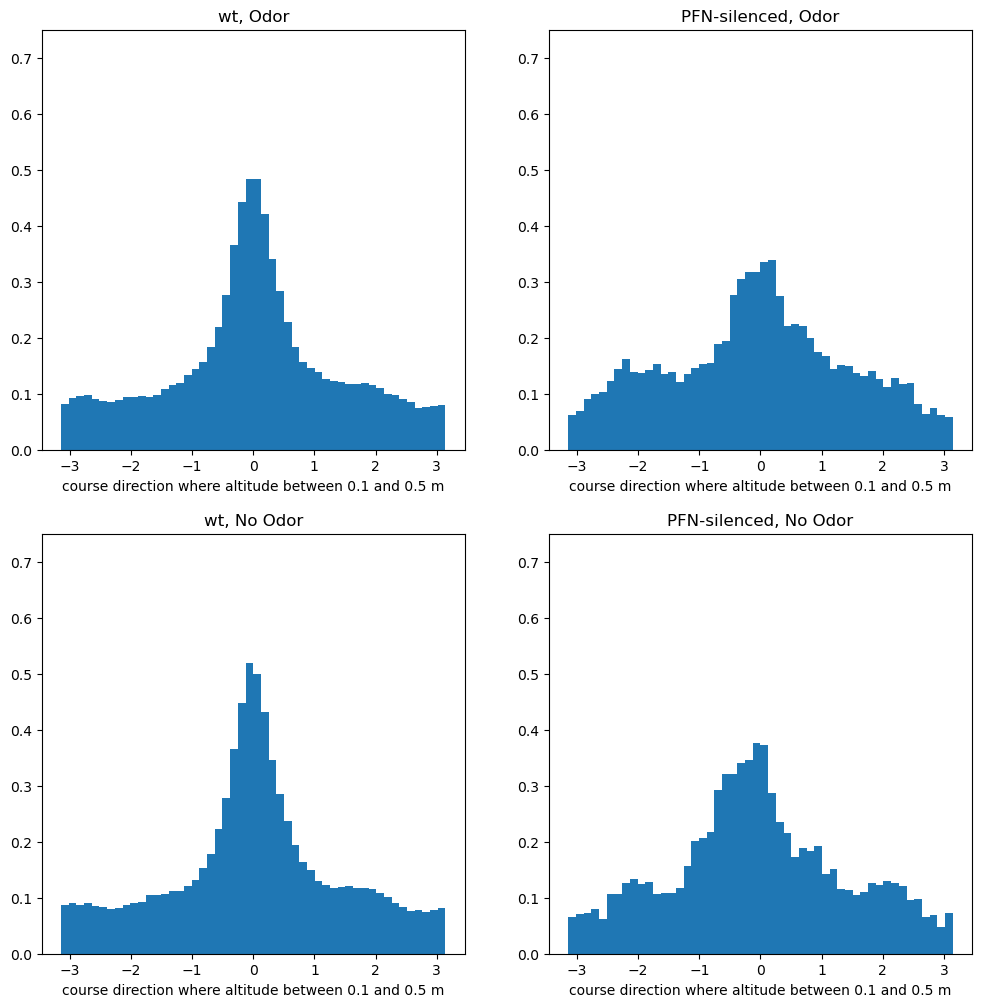

In [46]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
q = 'braid_flow_controls > 0 and z > 0.1 and z < 0.5 and speed_xy > 0.02 and speed_xy < 1'
ax[0,0].hist(wt_braid_df.query(q)['course'],bins=50,density=True);
ax[0,0].set_title('wt, Odor')
ax[0,0].set_xlabel('course direction where altitude between 0.1 and 0.5 m')
ax[0,0].set_ylim(0.0,0.75)
ax[0,1].hist(PFNsil_braid_df.query(q)['course'],bins=50,density=True)
ax[0,1].set_title('PFN-silenced, Odor')
ax[0,1].set_xlabel('course direction where altitude between 0.1 and 0.5 m');
ax[0,1].set_ylim(0.0,0.75);
q = 'braid_flow_controls == 0 and z > 0.1 and z < 0.5 and speed_xy > 0.02 and speed_xy < 1'
ax[1,0].hist(wt_braid_df.query(q)['course'],bins=50,density=True);
ax[1,0].set_title('wt, No Odor')
ax[1,0].set_xlabel('course direction where altitude between 0.1 and 0.5 m')
ax[1,0].set_ylim(0.0,0.75)
ax[1,1].hist(PFNsil_braid_df.query(q)['course'],bins=50,density=True)
ax[1,1].set_title('PFN-silenced, No Odor')
ax[1,1].set_xlabel('course direction where altitude between 0.1 and 0.5 m');
ax[1,1].set_ylim(0.0,0.75);

# Compute and plot angular dispersion

In [13]:
create_unwrapped_heading_column(wt_braid_list,'course')
create_unwrapped_heading_column(PFNsil_braid_list,'course')

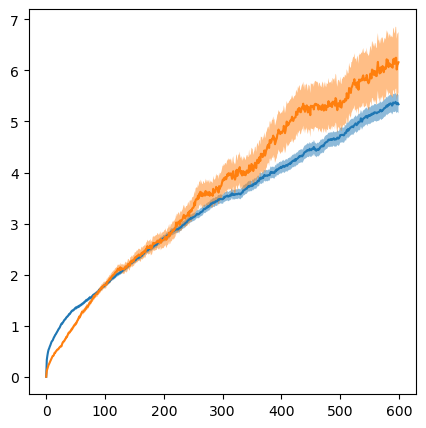

In [14]:
fig,ax = plt.subplots(figsize=(5,5))
wt_angdisps = compute_angular_dispersion(wt_braid_list,0,600,plotting=True,ax=ax)
pfnsil_angdisps = compute_angular_dispersion(PFNsil_braid_list,0,600,plotting=True,ax=ax)

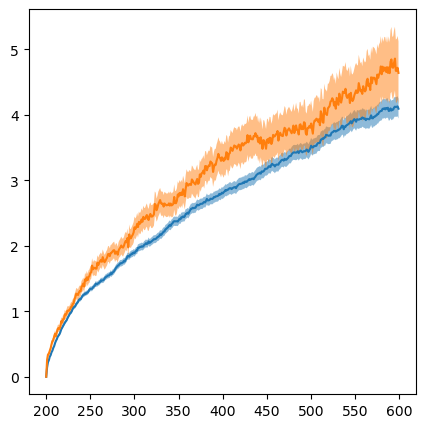

In [16]:
## only from 200-600
fig,ax = plt.subplots(figsize=(5,5))
_ = compute_angular_dispersion(wt_braid_list,200,600,plotting=True,ax=ax)
_ = compute_angular_dispersion(PFNsil_braid_list,200,600,plotting=True,ax=ax)

# Plot groundspeed over time

In [17]:
wt_gspds, wt_gspd_mean, wt_gspd_sem = get_mean_over_time(wt_braid_list,'speed_xy',600)
PFNsil_gspds, PFNsil_gspd_mean, PFNsil_gspd_sem = get_mean_over_time(PFNsil_braid_list,'speed_xy',600)

In [18]:
len(PFNsil_braid_list),len(wt_braid_list)

(944, 2840)

In [19]:
trajlens = [len(trajec) for trajec in wt_braid_list]
minlen = min(trajlens)
minlen

51

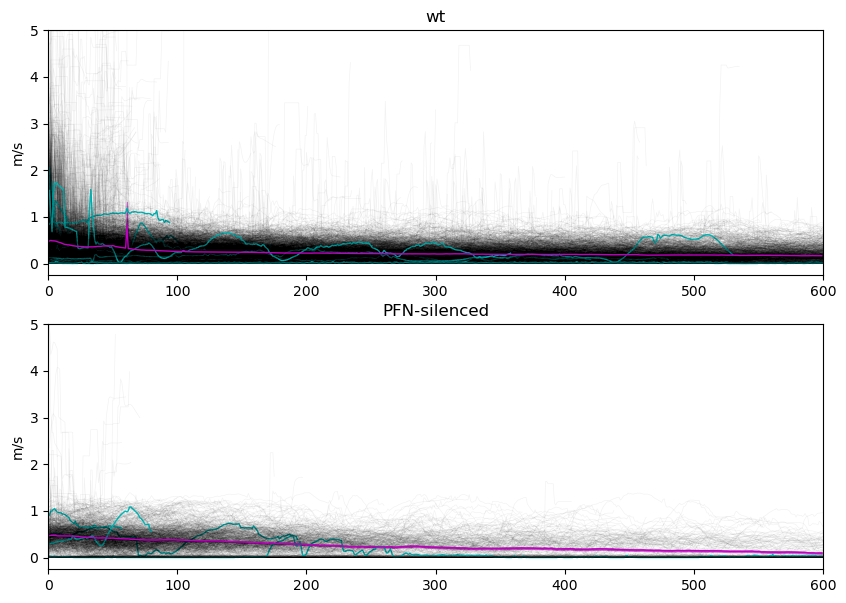

In [20]:
fig,ax = plt.subplots(2,1,figsize=(10,7))

count=0
for trajec in wt_braid_list:
    if count%250==0:
        ax[0].plot(np.arange(1,len(trajec)+1),trajec.speed_xy,'c',linewidth=1)
    ax[0].plot(np.arange(1,len(trajec)+1),trajec.speed_xy,'k',linewidth=0.5,alpha=0.05)
    count+=1
    
count=0
for trajec in PFNsil_braid_list:
    if count%250==0:
        ax[1].plot(np.arange(1,len(trajec)+1),trajec.speed_xy,'c',linewidth=1)
    ax[1].plot(np.arange(1,len(trajec)+1),trajec.speed_xy,'k',linewidth=0.5,alpha=0.05)
    count+=1
    
ax[0].set_xlim(0,600)
ax[0].set_ylim(-0.25,5)
ax[0].set_title('wt')
ax[0].set_ylabel('m/s')
ax[1].set_xlim(0,600)
ax[1].set_ylim(-0.25,5)
ax[1].set_title('PFN-silenced')
ax[1].set_ylabel('m/s')

ax[0].plot(wt_gspd_mean,'m',linewidth=1);
ax[0].fill_between(np.arange(0,600),
                   wt_gspd_mean-wt_gspd_sem,
                   wt_gspd_mean+wt_gspd_sem,color='m',alpha=0.5)
ax[1].plot(PFNsil_gspd_mean,'m',linewidth=1)
ax[1].fill_between(np.arange(0,600),
                   PFNsil_gspd_mean-PFNsil_gspd_sem,
                   PFNsil_gspd_mean+PFNsil_gspd_sem,color='m',alpha=0.5);

# Plot groundspeed distributions, PFN silenced vs. WT

In [21]:
wt_braid_df

,index,obj_id,frame,timestamp,x,y,z,xvel,yvel,zvel,...,P44,P55,obj_id_unique,speed_xy,course,course_smoothish,ang_vel_smoothish,alicat_flow_rate,braid_flow_controls,binary_odor_value_for_cylindrical_plume
0,13288,911,547190,1.750988e+09,-0.508940,-0.092787,0.601269,-0.313339,0.294105,0.161826,...,0.022498,0.242128,20250626_170346_911,0.429744,2.387848,2.387962,2.208639,126.871860,150.0,0
1,13289,911,547191,1.750988e+09,-0.512110,-0.090019,0.603649,-0.315663,0.281363,0.207244,...,0.015698,0.084157,20250626_170346_911,0.422857,2.413582,2.410048,1.790788,126.872660,150.0,0
2,13290,911,547192,1.750988e+09,-0.515070,-0.087472,0.606155,-0.299772,0.261090,0.227090,...,0.015572,0.049142,20250626_170346_911,0.397532,2.425054,2.423777,1.459278,126.873460,150.0,0
3,13291,911,547193,1.750988e+09,-0.517440,-0.085428,0.607274,-0.250405,0.214309,0.177631,...,0.015461,0.040152,20250626_170346_911,0.329592,2.433714,2.439234,2.408409,126.874260,150.0,0
4,13292,911,547194,1.750988e+09,-0.519858,-0.083519,0.607124,-0.244530,0.192029,0.097738,...,0.015419,0.038165,20250626_170346_911,0.310918,2.475881,2.471946,4.322529,126.875060,150.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105956,3829998,32803,6284452,1.751045e+09,0.107194,-0.069843,0.315482,0.694397,0.219885,-2.683031,...,0.140214,0.182348,20250626_170346_32803,0.728380,0.306667,0.305720,0.097841,128.009195,150.0,0
3105957,3829999,32803,6284453,1.751045e+09,0.114138,-0.067645,0.288652,0.694397,0.219885,-2.683031,...,0.160214,0.202348,20250626_170346_32803,0.728380,0.306667,0.307807,0.193757,128.010392,150.0,0
3105958,3830000,32803,6284454,1.751045e+09,0.121082,-0.065446,0.261822,0.694397,0.219885,-2.683031,...,0.180214,0.222348,20250626_170346_32803,0.728380,0.306667,0.309596,-0.443170,128.011589,150.0,0
3105959,3830001,32803,6284455,1.751045e+09,0.128026,-0.063247,0.234991,0.694397,0.219885,-2.683031,...,0.200214,0.242348,20250626_170346_32803,0.728380,0.306667,0.298944,-1.967903,128.012785,150.0,0


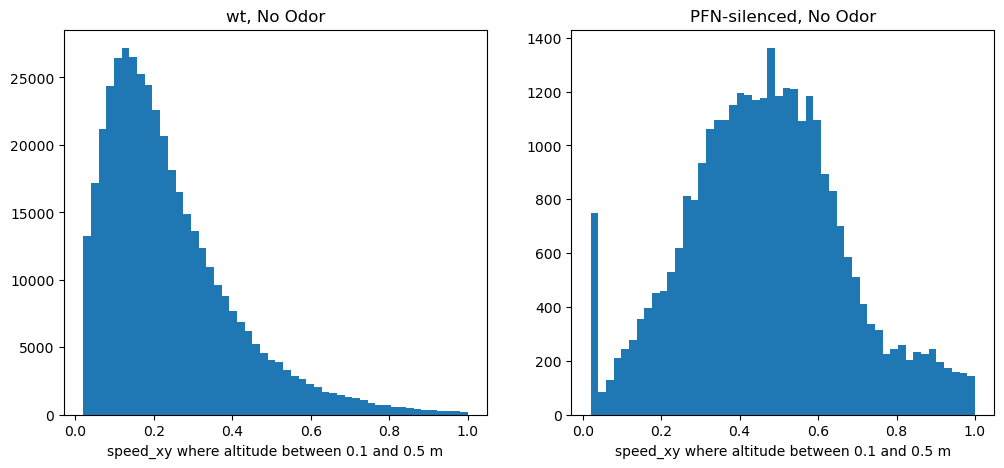

In [22]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
q = 'braid_flow_controls == 0 and z > 0.1 and z < 0.5 and speed_xy > 0.02 and speed_xy < 1'
ax[0].hist(wt_braid_df.query(q)['speed_xy'],bins=50);
ax[0].set_title('wt, No Odor')
ax[0].set_xlabel('speed_xy where altitude between 0.1 and 0.5 m')
ax[1].hist(PFNsil_braid_df.query(q)['speed_xy'],bins=50)
ax[1].set_title('PFN-silenced, No Odor')
ax[1].set_xlabel('speed_xy where altitude between 0.1 and 0.5 m');

# Plot correlation of groundspeed and z (altitude)

Because groundspeed has two distributions - one centered on 0.25-0.5 m/s and one near 0 m/s

Hypothesis: groundspeed is lower when the fly is nearer to the floor of the wind tunnel (z=0)

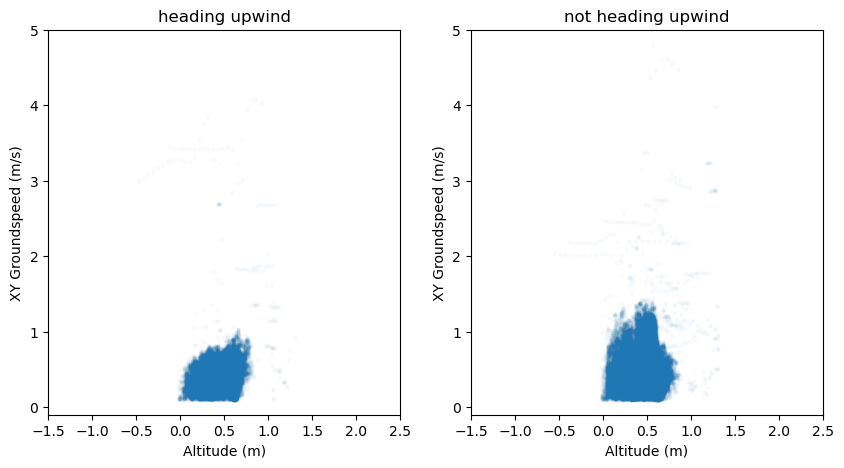

In [107]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
dat = PFNsil_braid_df.query('speed_xy > 0.1 and speed_xy < 5')
q = 'course_smoothish < 0.78 and course_smoothish > -0.78'
ax[0].scatter(dat.query(q).z,dat.query(q).speed_xy,s=5,alpha=0.02)
ax[0].set_ylim(-0.1,5)
ax[0].set_xlim(-1.5,2.5)
ax[0].set_xlabel('Altitude (m)')
ax[0].set_ylabel('XY Groundspeed (m/s)')
ax[0].set_title('heading upwind')

ax[1].scatter(dat.query('~('+q+')').z,dat.query('~('+q+')').speed_xy,s=5,alpha=0.02)
ax[1].set_ylim(-0.1,5)
ax[1].set_xlim(-1.5,2.5)
ax[1].set_xlabel('Altitude (m)')
ax[1].set_ylabel('XY Groundspeed (m/s)')
ax[1].set_title('not heading upwind');

Text(0.5, 1.0, 'not heading upwind')

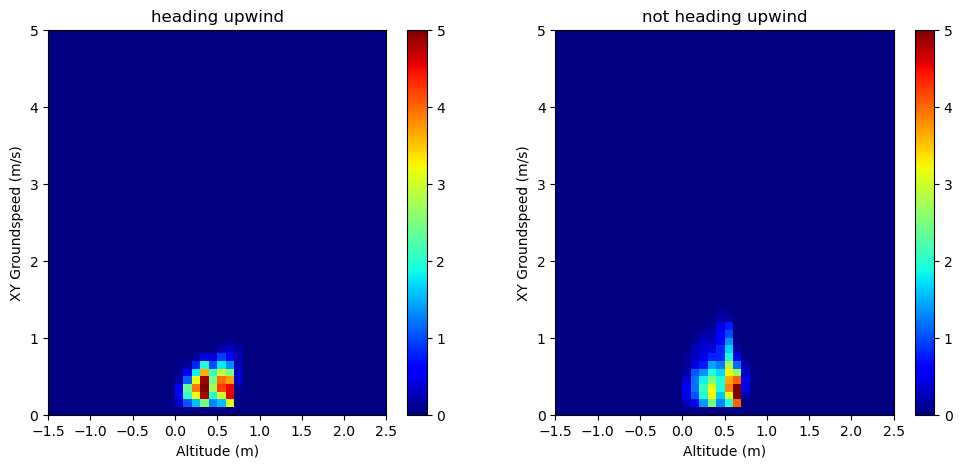

In [110]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

xedges = np.linspace(-1.5,2.5,41)
yedges = np.linspace(0,5,51)

Z, xedges, yedges = np.histogram2d(dat.query(q).z,dat.query(q).speed_xy,bins=(xedges,yedges),density=True)
Z = Z.T
X, Y = np.meshgrid(xedges, yedges)
pos = ax[0].pcolormesh(X, Y, Z,cmap='jet',vmin=0,vmax=5)#,norm=LogNorm(),clim=(100,50000)) #vmin=0,vmax=20000,cmap='jet')
fig.colorbar(pos)
ax[0].set_xlabel('Altitude (m)')
ax[0].set_ylabel('XY Groundspeed (m/s)')
ax[0].set_title('heading upwind')


Z, xedges, yedges = np.histogram2d(dat.query('~('+q+')').z,dat.query('~('+q+')').speed_xy,bins=(xedges,yedges),density=True)
Z = Z.T
X, Y = np.meshgrid(xedges, yedges)
pos = ax[1].pcolormesh(X, Y, Z,cmap='jet',vmin=0,vmax=5)#,norm=LogNorm(),clim=(100,5000))
fig.colorbar(pos);
ax[1].set_xlabel('Altitude (m)')
ax[1].set_ylabel('XY Groundspeed (m/s)')
ax[1].set_title('not heading upwind')


Hypothesis not correct for multiple threshold values of XY groundspeed (0.05-0.15); best exemplified by threshold = 0.1 m/s

# Plot correlation of upwind groundspeed and odor on

How do we calculate upwind velocity?

from Alvarez-Salvado et al. 2018: "Upwind velocity was calculated using the derivative of the filtered Y coordinates divided by the time interval of 20 ms."

#### Important! From Floris's ppt, it would seem that the odor source is where x coordinate = 1.0. Advancing along y axis does not move upwind - advancing along x does!

In [63]:
xs = np.zeros((600,len(wt_braid_list)))
xs[:,:] = np.nan

count=0
for trajec in wt_braid_list:
    s = min([len(trajec),600])
    xs[:s,count] = trajec.x.iloc[:s]
    count+=1

ValueError: operands could not be broadcast together with shapes (2839,) (600,) 

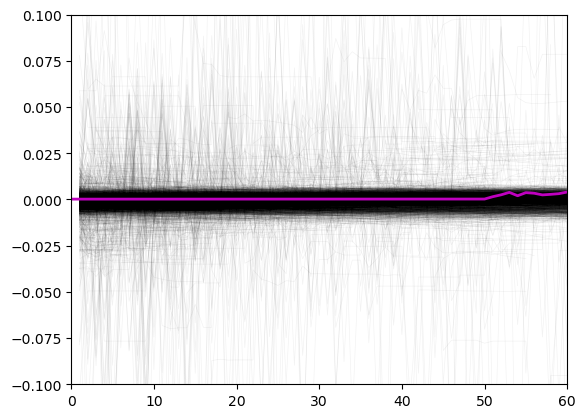

In [89]:
fig,ax = plt.subplots()

count=0
for trajec in wt_braid_list:
    #if count%250==0:
    #    ax.plot(np.arange(1,len(trajec)),np.diff(trajec.x))
    ax.plot(np.arange(1,len(trajec)),np.diff(trajec.x),'k',linewidth=0.5,alpha=0.05)
    count+=1
    
ax.set_xlim(0,60)
ax.set_ylim(-0.1,0.1)
ax.plot(np.nanmean(np.diff(xs),axis=1),'m',linewidth=2);
se = np.divide(np.nanstd(np.diff(xs),axis=1),np.sqrt(np.diff(xs).shape[1] - np.isnan(np.diff(xs)).sum(axis=1)))

ax.fill_between(np.arange(0,600),
                (np.nanmean(np.diff(xs),axis=1)-se),
                (np.nanmean(np.diff(xs),axis=1)+se),
                color='m',alpha=0.5);

In [95]:
thing = np.diff(xs,axis=1)
for i in range(53):
    print(len(xs[i,:]),np.nanmean(thing[i,:]))

2840 0.00018915493100307674
2840 0.00019027170084168676
2840 0.00019132022516221922
2840 0.0001921706890862965
2840 0.00019302229492031261
2840 0.000193987574450555
2840 0.00019512165436059192
2840 0.00019627269596458638
2840 0.00019732092580709965
2840 0.00019838238885081522
2840 0.0001995356472122229
2840 0.0002007090653677728
2840 0.00020191327660568512
2840 0.00020311243574028335
2840 0.00020447984763296987
2840 0.0002055591460119609
2840 0.0002066880805679409
2840 0.00020768463346603985
2840 0.00020864526412649884
2840 0.00020955257837442385
2840 0.00021026233885451868
2840 0.00021101466653211773
2840 0.00021178863316125612
2840 0.00021260271387700018
2840 0.00021354248276481093
2840 0.00021456699078278578
2840 0.00021561244064234142
2840 0.00021671150868575936
2840 0.000217815829619253
2840 0.00021918326647777514
2840 0.00022041279346265101
2840 0.00022154211847929612
2840 0.00022265157829357902
2840 0.00022333135285931732
2840 0.00022450166619425156
2840 0.00022554178557239799
2

(-0.5, 0.5)

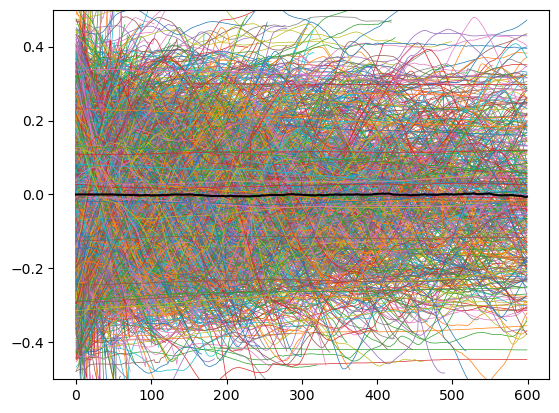

In [54]:
fig,ax = plt.subplots()
ax.plot(np.diff(ys),linewidth=0.5)
ax.plot(np.nanmean(np.diff(ys),axis=1),'k')
ax.set_ylim(-0.5,0.5)

(0.0, 600.0)

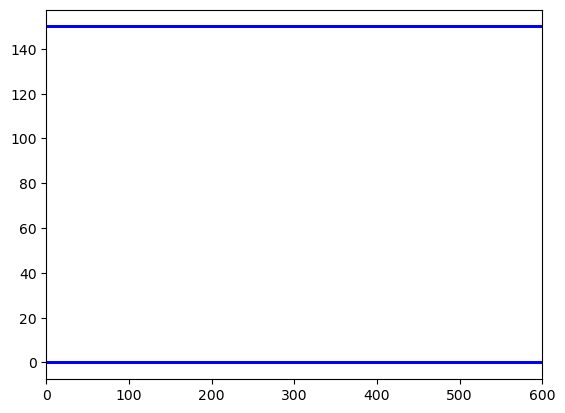

In [47]:
fig,ax = plt.subplots()

count=0
for trajec in braid_list:
    #if count%330==0:
    #    ax.scatter(np.arange(1,len(trajec)+1),trajec.braid_flow_controls)
    ax.scatter(np.arange(1,len(trajec)+1),trajec.braid_flow_controls,1,'b',alpha=0.05)
    count+=1
    
ax.set_xlim(0,600)
#ax.set_ylim(-0.1,0.1)

# Plot delta-Groundspeed

(-0.15, 0.15)

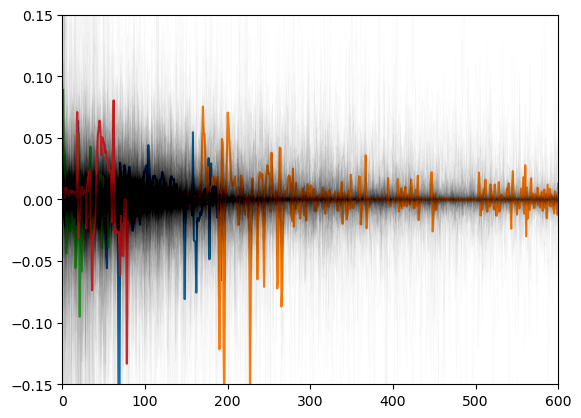

In [85]:
fig,ax = plt.subplots()

count=0
for trajec in braid_list:
    if count%250==0:
        ax.plot(np.arange(1,len(trajec)),np.diff(trajec.speed_xy))
    ax.plot(np.arange(1,len(trajec)),np.diff(trajec.speed_xy),'k',linewidth=0.5,alpha=0.02)
    count+=1
    
ax.set_xlim(0,600)
ax.set_ylim(-0.15,0.15)
#ax.plot(np.nanmean(np.diff(temp),axis=1),'m',linewidth=2)

# Scratch paper

In [9]:
long_obj_ids = braid_slicing.get_long_obj_ids_fast_pandas(braid_df, length=100) # therefore dt = 0.01?